In [1]:
"""
glowtts 用推論のテスト

glowtts + MB-Melgan


"""

'\nglowtts 用推論のテスト\n\nglowtts + MB-Melgan\n\n\n'

In [1]:
import yaml
import math
import torch
from torch import nn
import torch.nn.functional as F
import sys
sys.path.append('../')


import seaborn as sns
import matplotlib.pyplot as plt
from Utils.build_dataloader import build_dataloader
from train import get_data_path_list
from PIL import Image


%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = [ 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

sys.path.append('../../../Vocoders/')
%load_ext autoreload
%autoreload 2

In [2]:
melgan_config = "../../../Vocoders/ParallelWaveGAN/Configs/melgan_config.yml"
melgan_config = yaml.safe_load(open(melgan_config))
from ParallelWaveGAN.Networks.build_model import build_model as melgan_build_model
from ParallelWaveGAN.Utils.losses.pqmf import PQMF, OldPQMF
melgan_model = melgan_build_model(
    generator_type=melgan_config['generator_type'], 
    discriminator_type=melgan_config['discriminator_type'],
    model_params={
        'generator': melgan_config['generator_params'],
        'discriminator': melgan_config['discriminator_params']
    }
)[0]
pqmf = PQMF(4)
old_pqmf = OldPQMF(4, cutoff_ratio=0.15)
melgan_path = "../../../Vocoders/ParallelWaveGAN/logs/20200622/epoch_660.pth"
#
melgan_path = "../../../Vocoders/ParallelWaveGAN/logs/20200716/epoch_995.pth"
#melgan_path = "../../../Vocoders/ParallelWaveGAN/logs/20200814/epoch_645.pth"
melgan_model.load_state_dict(torch.load(melgan_path, map_location='cpu')['model']['generator'])


<All keys matched successfully>

In [3]:
data_path = "../Data/nospace_removeST/mzk_val_list.txt"
data_path = "../Data/nospace_removeST/val_list.txt"
#data_path = "../Data/nospace/mzk_train_list.txt"
with open(data_path, 'r') as f:
    data_list = f.readlines()


config = yaml.safe_load(open('../logs/20200629_pitch/config3.yml'))
#config = yaml.safe_load(open('../Configs/config8.yml'))


batch_size = 1
val_dataloader = build_dataloader(data_list,
                                  batch_size=batch_size,
                                  validation=True,
                                  num_workers=0,
                                  collate_config=config.get('collate_params', {'return_wave': True}),
                                  dataset_config=config.get('dataset_parasm', {}))



DEBUG:Utils.build_dataloader:sr: 24000
n_fft: 2048
hop_length: 300
win_length: 1200


In [4]:
#config['model_params']['config']['use_f0']= False
from Networks.build_model import build_model
model = build_model(model_params=config['model_params'])
#model_path = '../logs/20200629_pitch/epoch_00500.pth'
model_path = '../logs/20200705_mutipitch/epoch_00580.pth'
# model_path = '../logs/20200710_mzk/epoch_00500.pth'
# model_path = '../logs/20200721_mzkremovesymbol/epoch_03000.pth'
model_path = '../logs/20200726_mzkremovesymbol/epoch_01000.pth'

#model_path = '../logs/20200722_mzkremovesymbol/epoch_01600.pth'


model.load_state_dict(torch.load(model_path, map_location='cpu')['model'])
model.eval()
device = 'cpu'
model.to(device)
use_speakerids = True

In [5]:
from AutoEncoder.Networks.build_model import build_model as ae_build_model
ae, _ = ae_build_model('unet', use_pitch=False)
params = torch.load('../AutoEncoder/logs/20200710_multi/epoch_00200_generator.pth', map_location='cpu')
params = torch.load('../AutoEncoder/logs/20200727_multi/epoch_00120_generator.pth', map_location='cpu')

#params = torch.load('../AutoEncoder/logs/20200712_multipitch/epoch_00200_generator.pth', map_location='cpu')

ae.load_state_dict(params)
_ = ae.eval()

In [6]:


for idx, batch in enumerate(val_dataloader):
    batch = [b.to(device) if isinstance(b, torch.Tensor) else b for b in batch]
    text, text_lengths, mel_target, mel_target_lengths, f0, speaker_ids, waves, paths = batch
    speaker_ids = torch.LongTensor([103]).to(device)
    if idx == 353:
        break
        
#_style = torch.load('/mnt/ssd/Data/MultiDataset/mazoku_sr24kHz/yorinuki_014/yorinuki_14_1_wav.pth')[1].unsqueeze(0)
#style = (torch.log(1e-5 + _style) + 4) / 4
style = mel_target
print(speaker_ids)

tensor([103])


In [8]:
#%%timeit
with torch.no_grad():
    noise_scale = 0.5
    length_scale = 1.0
    (y_gen_tst, *r), attn_gen, *_, pitch = model.forward_with_target_alignment(text, text_lengths, 
                                                                               y=mel_target, y_lengths=mel_target_lengths,
                                                                               g=speaker_ids if use_speakerids else None, 
                                                                               pitch=f0,
                                                                               noise_scale=noise_scale, length_scale=length_scale)

In [9]:
#%%timeit
with torch.no_grad():
    noise_scale = 0.6
    length_scale = 1.0
    (y_gen_tst, *r), attn_gen, *_, pitch = model(text, text_lengths, 
                                          y=style, #mel_target,
                                          g=speaker_ids if use_speakerids else None, 
                                          gen=True, 
                                          noise_scale=noise_scale, length_scale=length_scale)


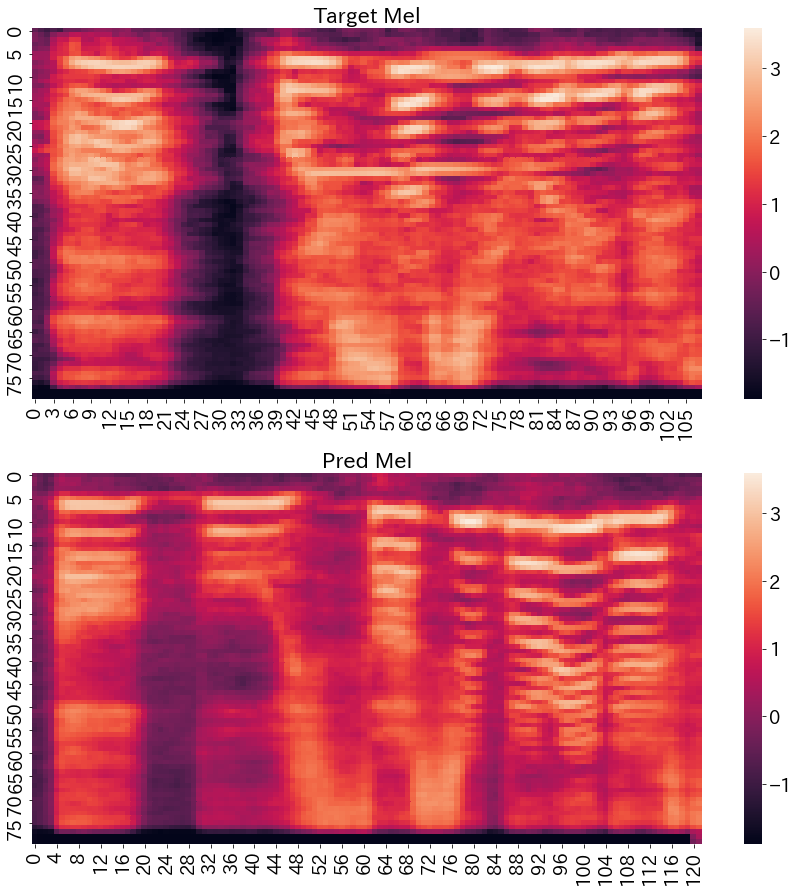

In [10]:
plt.rcParams['font.size'] = 18
fig, ax = plt.subplots(2, 1, figsize=(15, 15))
#ax[0].imshow(mel_target.cpu().numpy()[0])
#ax[1].imshow(y_gen_tst.cpu().numpy()[0])
sns.heatmap(mel_target.cpu().numpy()[0], ax=ax[0])
sns.heatmap(y_gen_tst.cpu().numpy()[0], ax=ax[1])
#sns.heatmap(ae(y_gen_tst.unsqueeze(1)).squeeze(1).detach().cpu().numpy()[0], ax=ax[2])
#ax[2].imshow(attn_gen[0, 0].cpu().numpy())
ax[0].set_title('Target Mel')
ax[1].set_title('Pred Mel')
#ax[2].set_title('Alignment')
plt.show()
plt.close()

In [40]:

#%%timeit
with torch.no_grad():
    x =y_gen_tst
    x = ae(x.unsqueeze(1)).squeeze(1)
    #
    x = style #mel_target
    y = melgan_model(x) #sample[1].transpose(0, 1).unsqueeze(0))
    y = pqmf.synthesis(y)


In [38]:
import IPython.display as ipd
#y = torch.load('/mnt/ssd/Data/MultiDataset/mazoku_sr24kHz/yorinuki_014/yorinuki_14_1_wav.pth')[0]
ipd.Audio(y.cpu().squeeze().numpy(), rate=24000)


In [41]:
import IPython.display as ipd
#y = torch.load('/mnt/ssd/Data/MultiDataset/mazoku_sr24kHz/yorinuki_014/yorinuki_14_1_wav.pth')[0]
ipd.Audio(y.cpu().squeeze().numpy(), rate=24000)


In [115]:
import IPython.display as ipd
#y = torch.load('/mnt/ssd/Data/MultiDataset/mazoku_sr24kHz/yorinuki_014/yorinuki_14_1_wav.pth')[0]
z = torch.load(waves[0])[0]
ipd.Audio(z.cpu().squeeze().numpy(), rate=24000)



In [149]:
### Style Transfer
from Networks import commons
for idx, batch in enumerate(val_dataloader):
    batch = [b.to(device) if isinstance(b, torch.Tensor) else b for b in batch]
    text, text_lengths, mel_target, mel_target_lengths, f0, speaker_ids, waves, paths = batch
    #speaker_ids = torch.LongTensor([103]).to(device)
    if idx == 110:        
        source_id = torch.LongTensor([[speaker_ids]])
        source_pitch = f0
        source_mel = mel_target
        source_lengths = mel_target_lengths
    if idx == 276:
        vc_target_id = torch.LongTensor([[speaker_ids]])
        vc_target_pitch = f0
        vc_target_mel = mel_target
        vc_target_lengths = mel_target_lengths
        break
        
length_scale = 1.0
source_max_length = None
with torch.no_grad():
    source_g_enc = model.emb_g(mel=source_mel.transpose(1, 2), spk_id=vc_target_id)
    vc_target_g_enc = model.emb_g(mel=vc_target_mel.transpose(1, 2), spk_id=vc_target_id)
    source_pitch_emb = model.pitch_emb(source_pitch)
    vc_target_pitch_emb = model.pitch_emb(
        source_pitch * ((
            vc_target_pitch[vc_target_pitch>0].mean() / (source_pitch[source_pitch>0].mean()))))
    source_g_dec = torch.cat([source_g_enc.expand(-1, -1, source_pitch_emb.size(-1)), source_pitch_emb], dim=1)
    vc_target_g_dec = torch.cat([vc_target_g_enc.expand(-1, -1, vc_target_pitch_emb.size(-1)), vc_target_pitch_emb], dim=1)
    
    source_mel, source_lengths, source_max_length = model.preprocess(source_mel, source_lengths, source_max_length)
    source_mel_mask = torch.unsqueeze(commons.sequence_mask(source_lengths, source_max_length), 1)
    source_z, _ = model.decoder(source_mel, source_mel_mask, g=source_g_dec, reverse=False)
    source_z += torch.rand_like(source_z) * 0.1
    vc_target_rec_mel, _ = model.decoder(source_z, source_mel_mask, g=vc_target_g_dec, reverse=True)
    
                                         

In [150]:

#%%timeit
with torch.no_grad():
    
    # x = ae(x.unsqueeze(1)).squeeze(1)
    #
    #x = style #mel_target
    source_y = melgan_model(source_mel) #sample[1].transpose(0, 1).unsqueeze(0))
    source_y = old_pqmf.synthesis(source_y).squeeze()
    vc_target_y = melgan_model(vc_target_mel) #sample[1].transpose(0, 1).unsqueeze(0))
    vc_target_y = old_pqmf.synthesis(vc_target_y).squeeze()
    vc_target_rec_y = melgan_model(vc_target_rec_mel) #sample[1].transpose(0, 1).unsqueeze(0))
    vc_target_rec_y = old_pqmf.synthesis(vc_target_rec_y).squeeze()

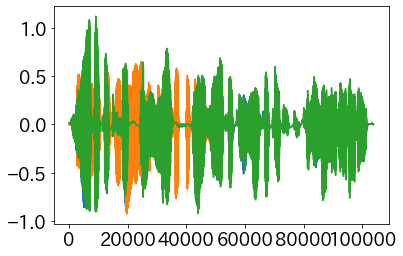

In [151]:
plt.plot(source_y.squeeze())
plt.plot(vc_target_y.squeeze())
plt.plot(vc_target_rec_y.squeeze())

In [152]:
ipd.Audio(vc_target_y.cpu().squeeze().numpy(), rate=24000)

In [153]:
ipd.Audio(source_y.cpu().squeeze().numpy(), rate=24000)

In [154]:
ipd.Audio(vc_target_rec_y.cpu().squeeze().numpy(), rate=24000)

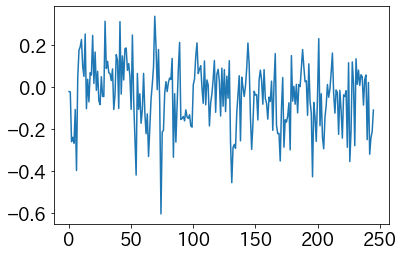

In [64]:
plt.plot(source_z[0].mean(dim=0))

In [148]:

vc_target_pitch[vc_target_pitch>0].mean() / (source_pitch[source_pitch>0].mean())

tensor(1.0244)

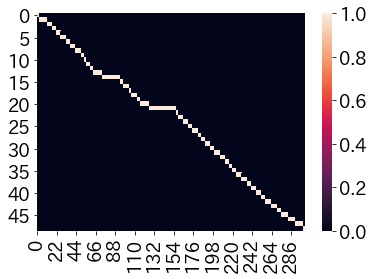

In [19]:
# import IPython.display as ipd
# ipd.Audio(wav.squeeze(), rate=24000)
sns.heatmap(attn_gen[0, 0].numpy())

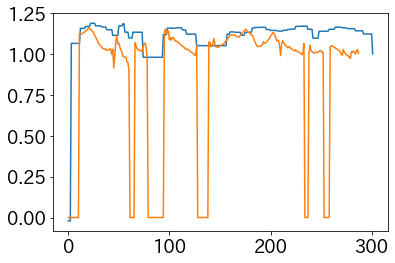

In [20]:
plt.plot(pitch.cpu().numpy()[0])
plt.plot(f0.cpu().numpy()[0])

In [43]:
text = ' dooreemiifaasooraasiidoo. doosiiraasodfaamiireedoo.'

f0 = torch.FloatTensor([0,261,261,261,294,294,294,330,330,330,
                        349,349,349,392,392,392,440,440,440,492,492,492,522,522,522,0]).unsqueeze(0) #/ 1.414

f0 = torch.log(f0 + 1) / 5
f0 = torch.cat([f0, f0.flip(dims=(1,))], dim=1)


In [44]:
len(text[0]), pitch.shape


(1, torch.Size([1, 122]))

In [45]:
from Utils.text_utils import TextCleaner
cleaner = TextCleaner('../Utils/word_index_dict.txt')


In [46]:
#text = ' anataosagizaitokibutusonkaizaideuqtaemasu. riyuwamociroNowakaridesune. anatagamiNnaokoNnaurawazadedamasise:bude:taohakaisitakaradesu. kakugonojunbiositeoitekudasai.'
#text = ' macikadomazoku zengokaN kouhyouhaTubaiTyu:desu!.'

#text = ' matikadomazoku.'
#pitch = model.pitch_preprocess('0112244555555330').reshape(1, 1, -1) 

#text = ' syokuhinme:ka:kiNmunotonainoyoNju:daidanseieisaNwakiNkyuujitaisengenkaijogo siNnyusyaiNoeigyousakinidoukousasetesigotooosieteita. itijiwaterewa:kubakarideiqsainominiikazu kaijogomonakanakakikaiganakaqta. kokonokago dousekisiteitasiNnyuusyaiNnohitorigasingatakoronaohaqsyou. puroyakyuu haNsiNkyaputeNnoitoharakeNtosensyuganijuuniniciyoru kousienkyuujoudeokonawaretahirosimatonosiaidemigiteokoqsetusi itiguNnosensyutourokuomaqsyousarerukotoninarimasita.'
text = ' macikado mazoku nikikeqteiomedetougozaimasu'
#text = ' coubuNnoyomiagetonaruto jaqkaNroboqtosawainamenaidesuga taNgonohatuoNnokakuniNdearebajuubuNdesu. amerikatoigirisunoiroNnaonseiwoerande hanasusupi:dogahayaikayuqkurikaniyoqtekikoekatagahenkasurukotomojiqkaNsitemitekudasai.'
#text = ' teitei.'
#text = ' syamiq syadoumisutoresuyu:ko.'
#text = ' .'
#text = ' momo,damedesu yametekudasai,!.'
# text = ' momonoza:koza:ko:zakociNpo.'
# text = ' momogawaruiNdesuyo.'
# text = ' koNnitiwa.'
#text = ' openisu.'
# f0 = torch.FloatTensor([0, ]).unsqueeze(0) / 1.4

#text = ' yukaninaritaitowa. oqcicaNkawaqtaseihekioomocidesune.'
#text = ' kyouwaiitenkidesune.'
#text = ' koharakonomisaN otanjo:biomedeto:gozaimasu.'
#text = ' momo yametekudasai.'
#text = ' kasa.'
#あなたを詐欺罪と器物損壊罪で訴えます！理由はもちろんお分かりですね？あなたが皆をこんなウラ技で騙し、セーブデータを破壊したからです！覚悟の準備をしておいて下さい。
text = cleaner(text)
text = torch.LongTensor(text).unsqueeze(0).to(device)
text_lengths = torch.LongTensor([text.shape[1]]).to(device)
model.to(device)
melgan_model.to(device)
pqmf = PQMF(4)
pqmf.to(device)

#

PQMF(
  (pad_fn): ConstantPad1d(padding=(31, 31), value=0.0)
)

In [73]:
#%%timeit

with torch.no_grad():
    noise_scale = 0.4
    length_scale = 1.
    (y_gen_tst, *r), attn_gen, *_ = model(
        text, text_lengths, gen=True, 
        y=style,
        #pitch=f0,
        pitch_bias=-0, #pitch,
        g=speaker_ids  if use_speakerids else None, 
        noise_scale=noise_scale, 
        length_scale=length_scale)

In [82]:
#%%timeit
with torch.no_grad():
    x = y_gen_tst
    if x.size(2) <= 8:
        lpad = x[:, :, :1].expand(-1, -1, 6)
        rpad = x[:, :, -1:].expand(-1, -1, 6)
        x = torch.cat([lpad, x, rpad], dim=2)
        print(x.shape)
    #x = torch.nn.ReflectionPad1d(2)(x)
    #x = mel_target
    
    #pt = torch.bmm(f0.unsqueeze(1), attn_gen[0])
    x = ae(x.unsqueeze(1), #pt
          ).squeeze(1)
    _y = melgan_model(x) #sample[1].transpose(0, 1).unsqueeze(0))
    #for i in range(3, 4):
    #    _y[:, 1] *= 0.4
    y = pqmf.synthesis(_y) 
    #y = torch.max(torch.zeros(1), (y.abs() - 0.005)) * y.sign()
    

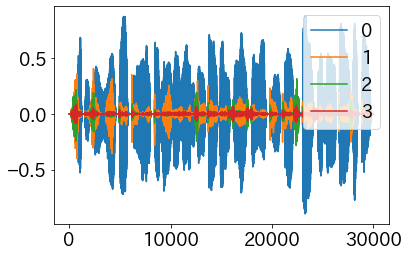

In [79]:
for i in range(4):
    plt.plot(_y[0, i, :30000].numpy(), label='%d' % i)
plt.legend()
    

In [80]:
import IPython.display as ipd
ipd.Audio(y.squeeze().cpu().numpy(), rate=24000)

In [83]:
import IPython.display as ipd
ipd.Audio(y.squeeze().cpu().numpy(), rate=24000)

In [30]:
import IPython.display as ipd
ipd.Audio(y.squeeze().cpu().numpy(), rate=24000)

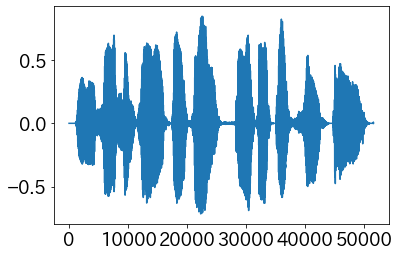

In [84]:
plt.plot(y[0, 0])


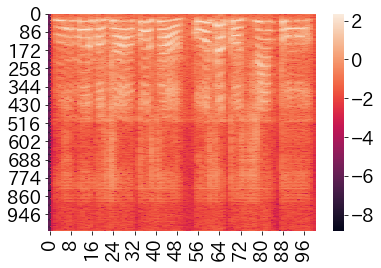

In [110]:
import librosa
y_arr = y.squeeze().cpu().numpy()
z = librosa.core.stft(y_arr)
power, angle = np.abs(z), np.angle(z)
power[512:] *= 0.5
sns.heatmap(np.log10(power))
recz = power * np.cos(angle) + 1j * power * np.sin(angle)
rec = librosa.core.istft(recz)

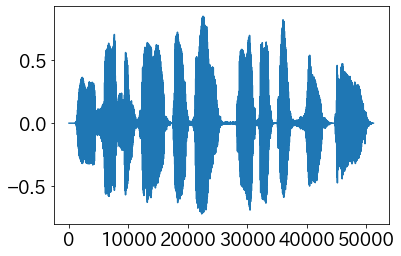

In [111]:
plt.plot(rec)

In [112]:
import IPython.display as ipd
ipd.Audio(rec, rate=24000)

In [243]:
unit = 2 * (torch.log(torch.FloatTensor([2])) / 12) / 5 


In [254]:
data = torch.load('/mnt/ssd/Data/DataForAE3/JSUT_24kHz/basic5000/wav/BASIC5000_0001_wav.pth')


In [258]:
pitch = data[-1]

In [21]:
# pitch input 